We are going to vectorize the surnames, we will obtain a vector for each surname in the form of hot encoded with all characters 
of the Alphabet, because depending of the language, we may have characters that we are not aware of, therefore, we will use the
training dataset to form the vocabulary that will be used for the one-hot encoded vector.

In [1]:
import torch
import pandas as pd
import utils

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

In [3]:
dataset = utils.dataset_processing.create_vocabulary(train,validation,test)

In [4]:
dataset.transform_encoded_dataset()

##### Model

In [5]:
class MLP(nn.Module):
    def __init__(self,input_dim,hidden_dim_1, hidden_dim_2,output_dim):
        
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)
        
    def forward(self, x_in, apply_sigmoid=False):
        
        hidden_output_1 = F.relu(self.fc1(x_in))
        hidden_output_2 = F.relu(self.fc2(hidden_output_1))
        y_out = self.fc3(hidden_output_2)
        
        
        if apply_sigmoid:
            y_out = F.softmax(y_out,dim=1)
        return y_out

In [6]:
model = MLP(len(dataset.surname_vocab),100,40,len(dataset.nation_vocab))

In [7]:
model

MLP(
  (fc1): Linear(in_features=52, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=18, bias=True)
)

##### Loss, Optimizer and Dataloader

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model.parameters(), lr = 1)
n_batch = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We create the datalader with the encoded train dataset and the ratings of the training dataset
loader = utils.data_loader_luis(dataset.train_surname_encoded,dataset.train_nation_encoded,n_batch)

In [9]:
n_epochs = 250
error = []
error_validation = []


for epoch_i in range(n_epochs):
    for batch_i in range(n_batch):
    
        # Step 0: Generate the data for training
        x_data, targets = loader.batch()
        
        
        # Step 1: set up all the gradients in the model to zero, in order to avoid the accumulation of  
        # the gradients in each iteration
        model.zero_grad()
        
        
        # Step 2: compute the forward pass of the model
        y_pred = model(x_data.float().squeeze()).to(device)
        y_pred_validation = model(dataset.validation_surname_encoded.float()).to(device)
        
        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_function(y_pred,targets.long().to(device))
        loss_validation = loss_function(y_pred_validation,torch.Tensor(dataset.validation_nation_encoded).long().to(device))
        error.append(loss.to(torch.device('cpu')))
        error_validation.append(loss_validation.to(torch.device('cpu')))
        
        
        # Step 4: Propagate the loss signal backwards
        loss.backward()
        
        
        # Step 5: Trigger the optimizer to perfomr the update
        optimizer.step()
    

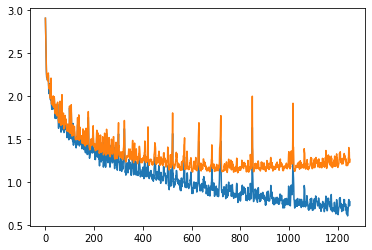

In [10]:
plt.plot(error)
plt.plot(error_validation)

In [11]:
def classifier(y_pred):
    y_pred_class = []
    for output in y_pred:
        values, indices = torch.max(output, 0)
        y_pred_class.append(indices)

    return y_pred_class

In [12]:
def accuracy(y_pred,true_target):
    
    y_pred_class = classifier(y_pred)
    true_target = list(true_target)
    count = 0
    for i in range(len(y_pred_class)):
        if int(y_pred_class[i])==int(true_target[i]):
            count += 1
        else:
            pass
    return count/len(y_pred_class)

In [13]:
y_pred_validation = model(dataset.validation_surname_encoded.float())

In [14]:
accuracy(y_pred_validation,dataset.validation_nation_encoded)

0.6560240963855422

In [15]:
y_pred_test = model(dataset.test_surname_encoded.float())

In [16]:
accuracy(y_pred_test,dataset.test_nation_encoded)

0.6420731707317073

### Evaluation

In [17]:
labels = list(dataset.nation_vocab.to_serializable()['token_to_idx'])

In [18]:
# y_pred_validation and dataset.validation_nation_encoded
def counfusion_matrix(labels,y_pred,ground_true):
    confusion_matrix = pd.DataFrame(0,index = labels, columns = labels)
    for i in range(len(y_pred)):
        confusion_matrix.iloc[int(ground_true[i]),int(y_pred[i])] += 1
        
    return confusion_matrix

##### Confusion matrix of the validation set

In [19]:
counfusion_matrix(labels,classifier(y_pred_validation),dataset.validation_nation_encoded)

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
Arabic,236,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0
Chinese,0,23,1,0,3,0,0,0,0,1,1,0,0,0,2,0,1,1
Czech,1,0,4,2,21,0,3,2,0,2,5,0,2,0,19,0,2,0
Dutch,0,2,3,6,10,0,6,0,1,1,3,0,0,0,4,0,0,0
English,7,4,12,10,297,4,32,1,6,14,14,0,1,0,37,0,8,0
French,0,0,1,0,20,5,3,0,0,1,2,0,0,0,3,0,0,0
German,0,0,2,3,26,3,41,0,0,0,2,2,0,0,7,0,0,1
Greek,0,0,0,1,2,0,1,8,1,2,3,0,0,0,5,0,1,0
Irish,1,0,0,1,9,0,2,0,5,4,4,0,0,0,1,0,1,0
Italian,2,5,1,0,8,2,0,2,2,40,5,0,0,1,14,0,8,0


##### Confusion matrix of the test set

In [20]:
counfusion_matrix(labels,classifier(y_pred_test),dataset.test_nation_encoded)

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
Arabic,236,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0
Chinese,0,19,0,0,4,0,1,0,0,0,4,2,0,0,2,0,0,1
Czech,2,0,7,1,15,0,11,2,0,2,4,0,0,1,16,0,1,0
Dutch,2,1,3,6,13,0,3,0,1,0,2,0,0,0,3,0,1,0
English,5,0,8,9,298,7,20,0,6,11,16,3,2,1,54,1,3,1
French,0,0,2,1,7,6,1,0,0,4,4,0,0,0,7,0,2,0
German,1,1,4,3,24,3,31,1,0,0,1,0,2,0,15,0,0,0
Greek,0,0,1,2,1,0,0,8,1,0,4,0,1,0,5,0,0,0
Irish,2,0,0,0,12,0,1,0,3,2,1,1,0,0,3,0,2,0
Italian,3,5,3,0,7,1,1,6,2,36,8,0,0,1,8,0,9,0
